In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a image."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(128, 128, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var", kernel_initializer='zeros', bias_initializer='zeros')(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 64, 64, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 65536)        0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [15]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(32 * 32 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((32, 32, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             196608    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 64, 64, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 128, 128, 32)      18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 128, 128, 1)       289       
Total params: 252,289
Trainable params: 252,289
Non-trainable params: 0
_____________________________________________________

In [16]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) * 0.1
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [17]:
Path = "/media/ug-ml/Drive2/felix-ML/VAE/VAE_Output_000/"

LACBED_Training = np.load(Path + "Training_Output.npy").reshape(-1, 128, 128, 1)
LACBED_Validation = np.load(Path + "Validation_Output.npy").reshape(-1, 128, 128, 1)
LACBED_Test = np.load(Path + "Test_Output.npy").reshape(-1, 128, 128, 1)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(LACBED_Training, epochs=10, batch_size=128, shuffle=True)

Epoch 1/10
46/46 [==============================] - 3s 76ms/step - loss: 9856.8991 - reconstruction_loss: 8526.3936 - kl_loss: 49.6884
Epoch 2/10
46/46 [==============================] - 3s 73ms/step - loss: 7136.5031 - reconstruction_loss: 7084.1914 - kl_loss: 19.8955
Epoch 3/10
46/46 [==============================] - 3s 74ms/step - loss: 7054.6992 - reconstruction_loss: 7057.1846 - kl_loss: 14.5606
Epoch 4/10
46/46 [==============================] - 3s 74ms/step - loss: 7061.4505 - reconstruction_loss: 7027.6670 - kl_loss: 12.7739
Epoch 5/10
46/46 [==============================] - 3s 73ms/step - loss: 7054.1925 - reconstruction_loss: 7014.1079 - kl_loss: 9.7589
Epoch 6/10
46/46 [==============================] - 3s 74ms/step - loss: 7027.0222 - reconstruction_loss: 6993.7451 - kl_loss: 8.4988
Epoch 7/10
46/46 [==============================] - 3s 73ms/step - loss: 6977.2031 - reconstruction_loss: 7001.1904 - kl_loss: 6.8470
Epoch 8/10
46/46 [==============================] - 3s 74m

(5786,)


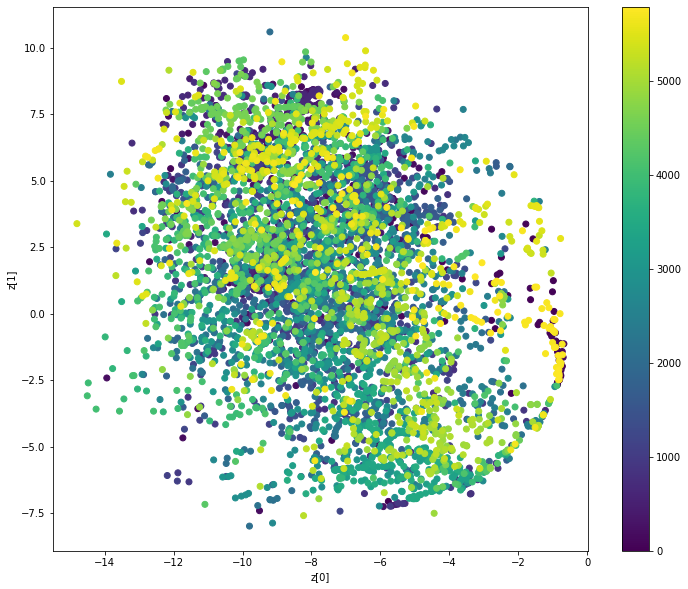

In [18]:
import matplotlib.pyplot as plt

labels = np.arange(LACBED_Training.shape[0])
print(labels.shape)
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(vae, LACBED_Training, labels)

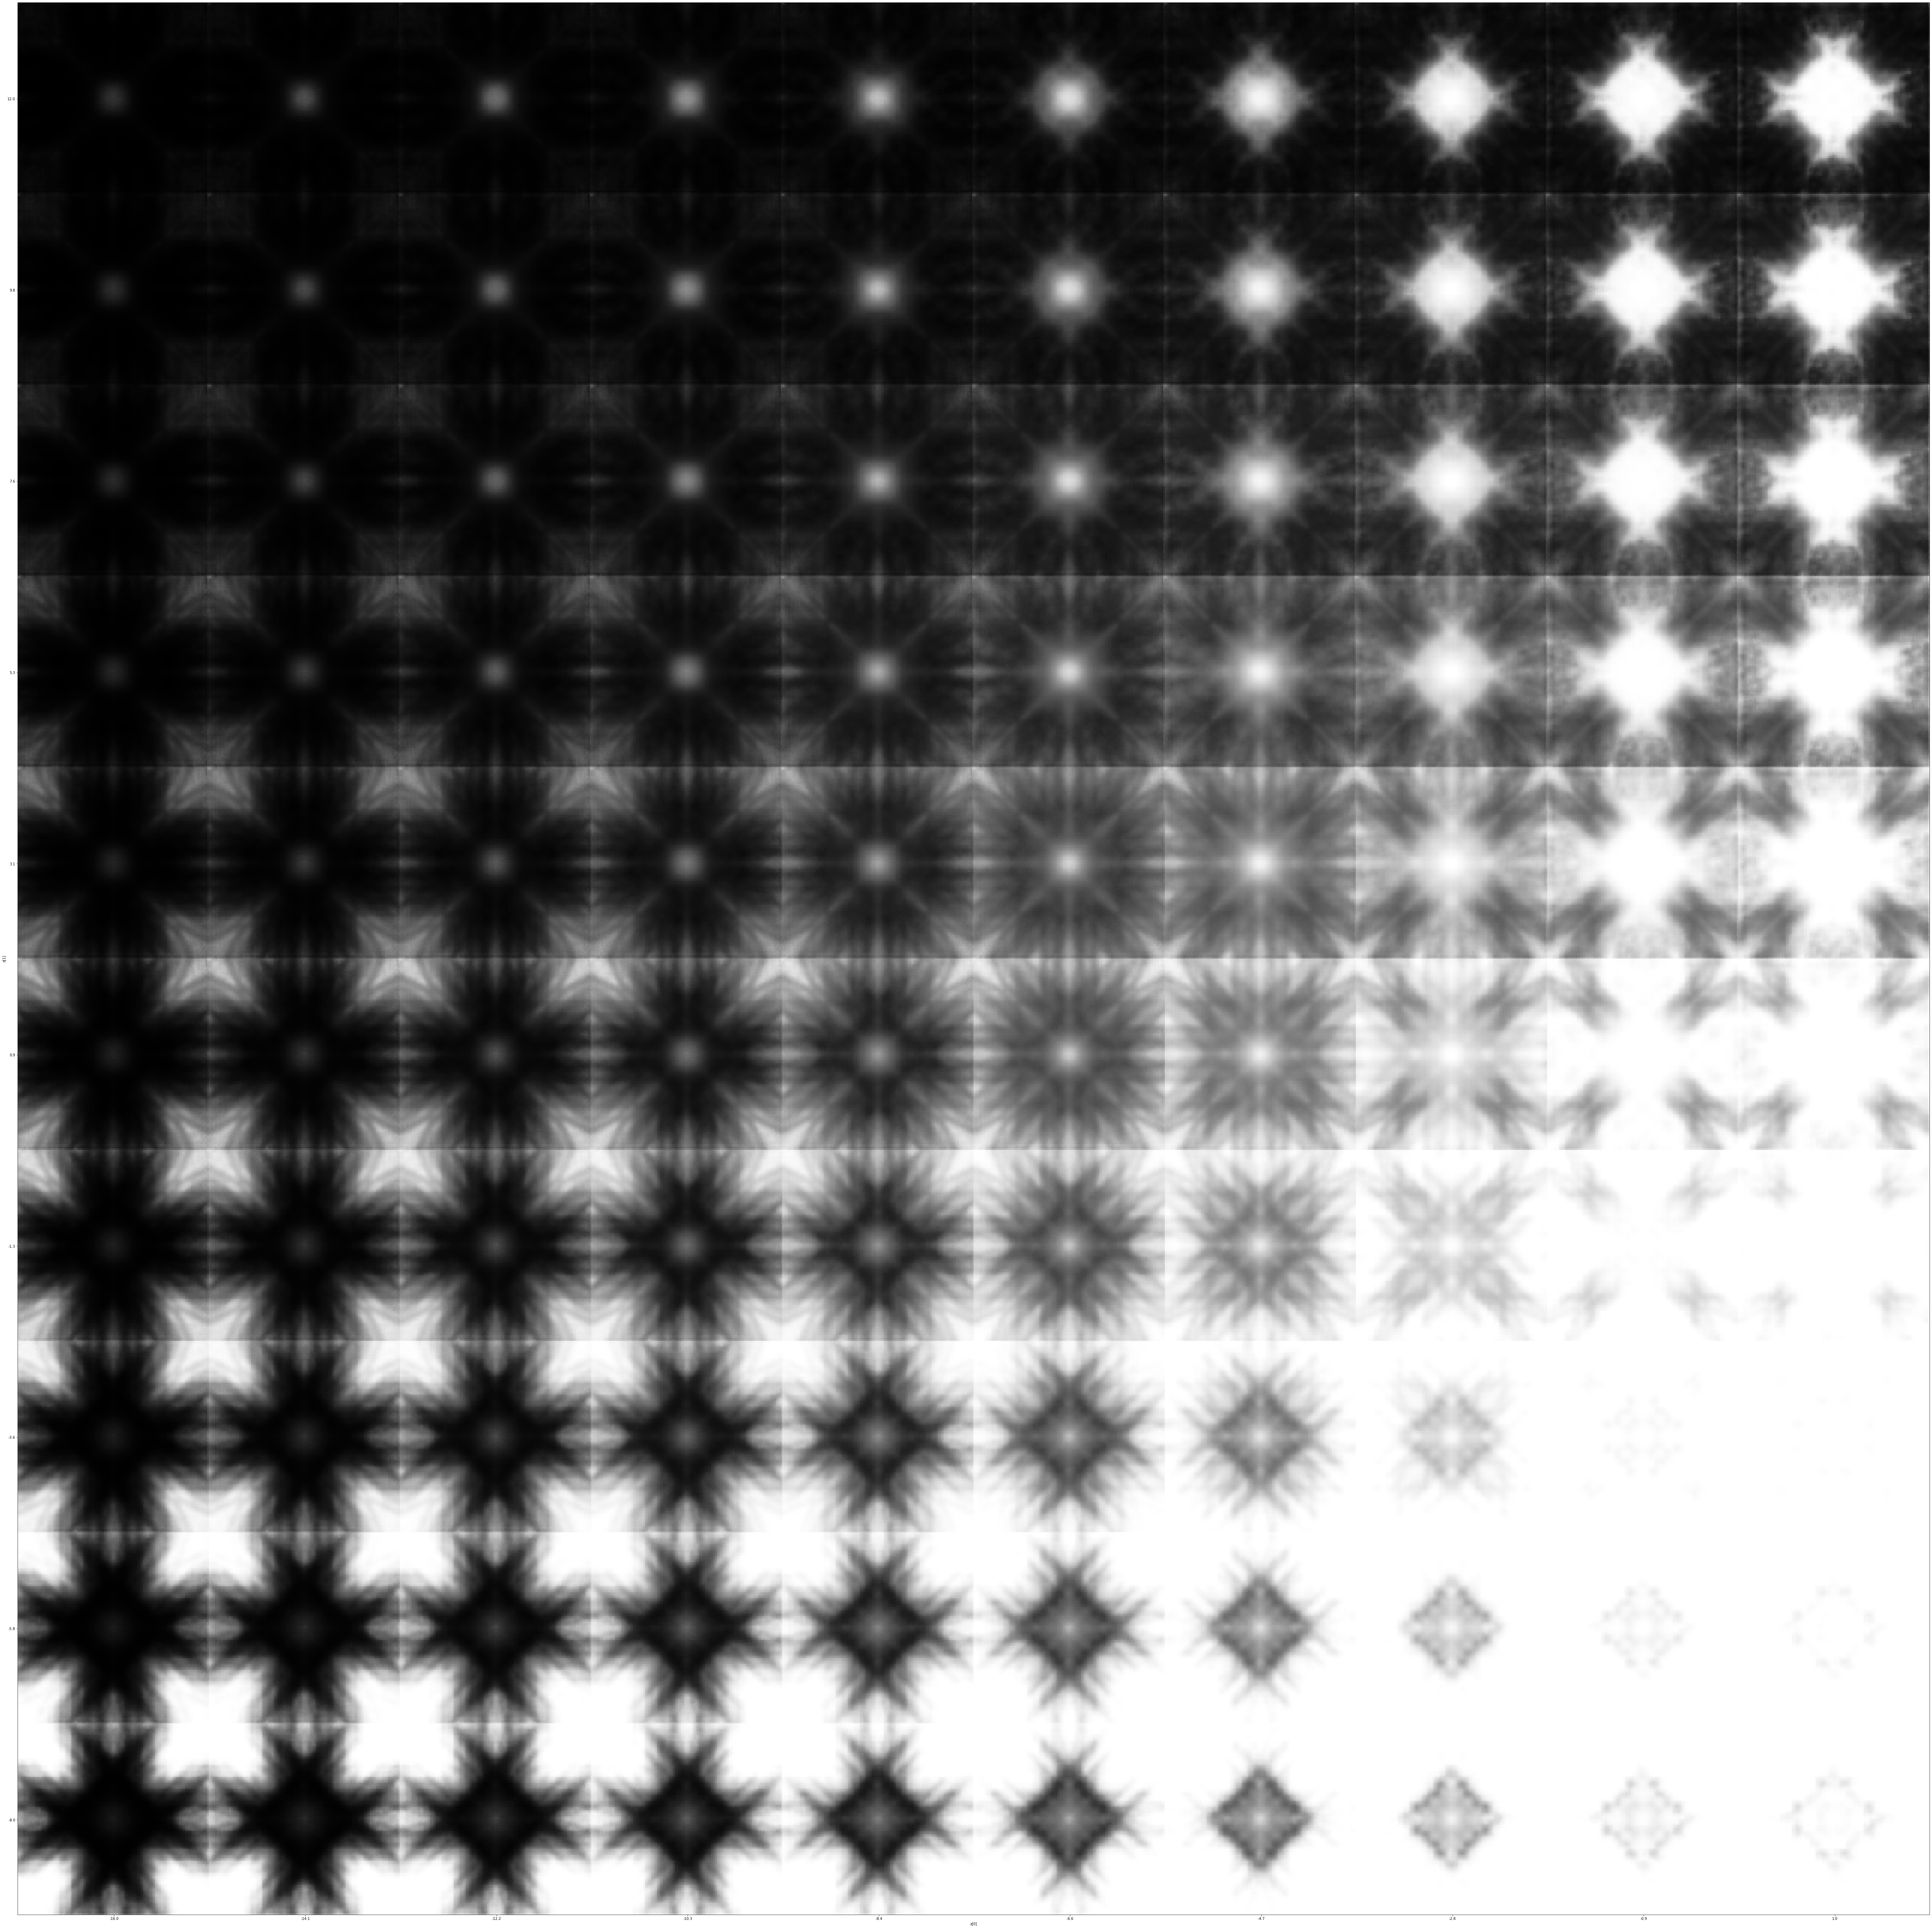

In [19]:
def plot_latent_space(vae, n=10, figsize=100):
    # display a n*n 2D manifold of image
    LACBED_size = 128
    scale = 10
    figure = np.zeros((LACBED_size * n, LACBED_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of image classes in the latent space
    #grid_x = np.linspace(-scale, scale, n)
    #grid_y = np.linspace(-scale, scale, n)[::-1]
    
    grid_x = np.linspace(-16, 1, n)
    grid_y = np.linspace(-8, 12, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            image = x_decoded[0].reshape(LACBED_size, LACBED_size)
            figure[
                i * LACBED_size : (i + 1) * LACBED_size,
                j * LACBED_size : (j + 1) * LACBED_size,
            ] = image

    plt.figure(figsize=(figsize, figsize))
    start_range = LACBED_size // 2
    end_range = n * LACBED_size + start_range
    pixel_range = np.arange(start_range, end_range, LACBED_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

/home/ug-ml/felix-ML/env/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


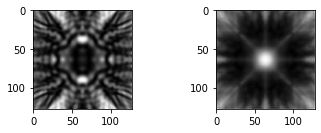

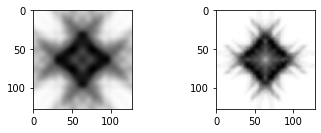

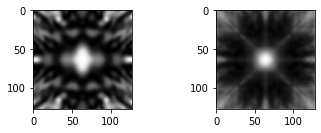

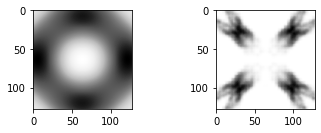

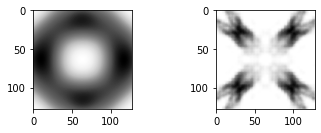

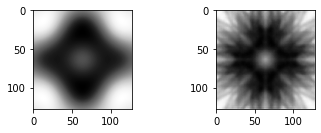

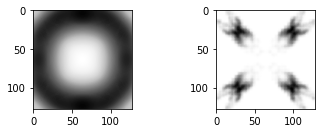

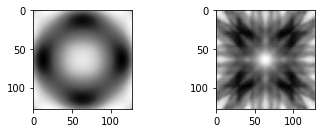

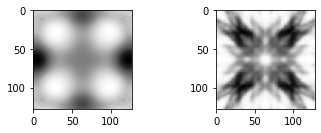

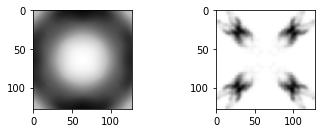

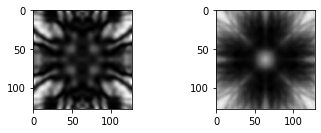

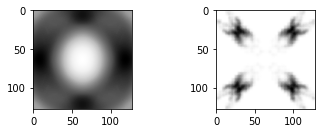

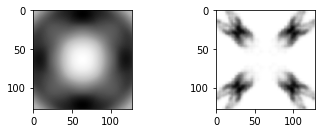

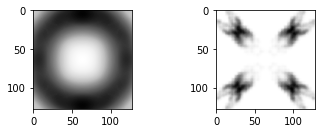

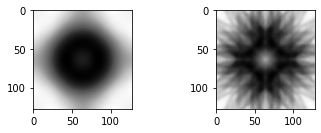

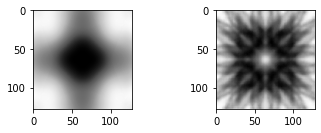

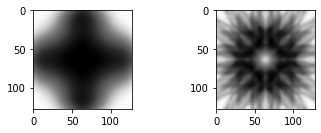

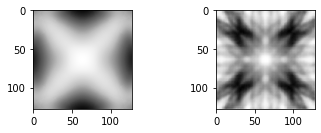

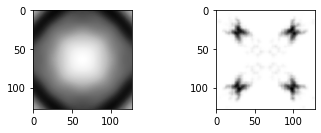

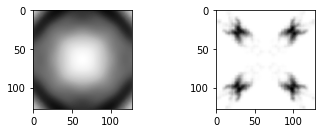

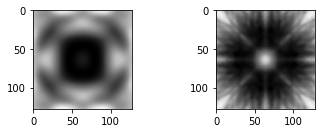

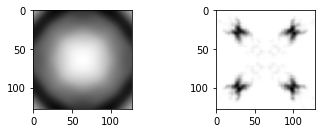

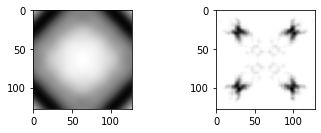

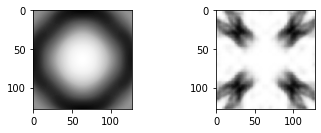

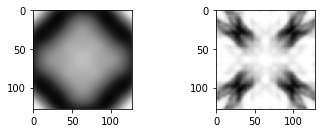

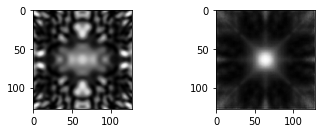

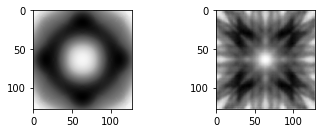

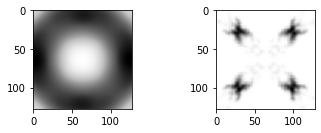

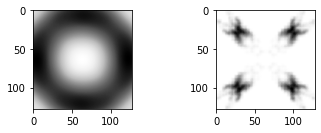

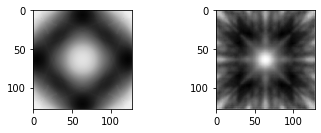

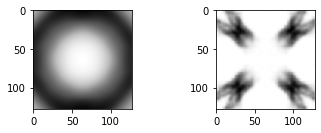

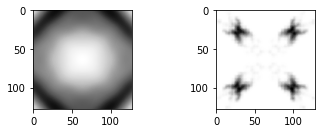

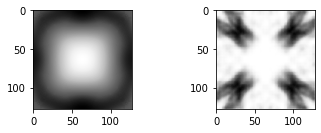

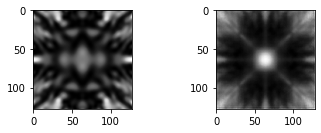

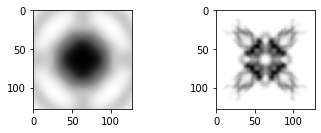

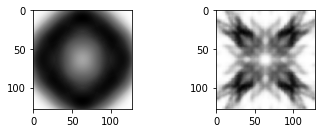

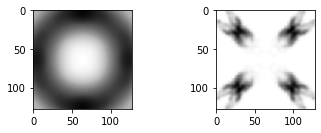

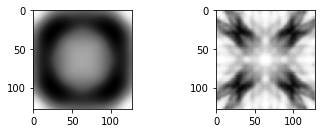

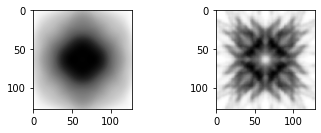

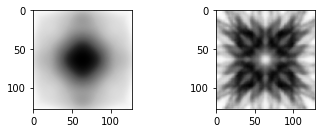

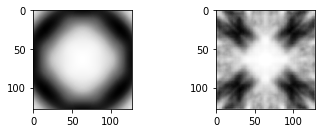

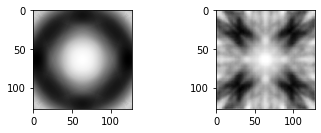

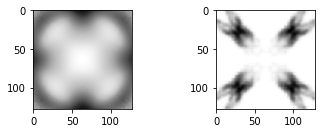

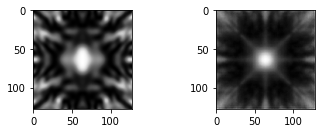

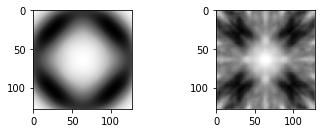

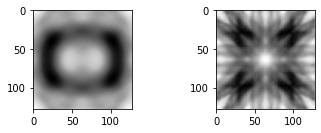

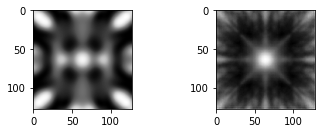

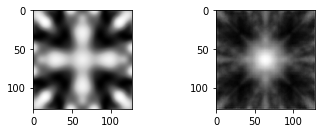

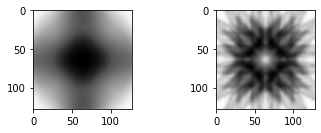

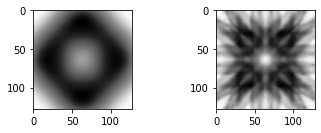

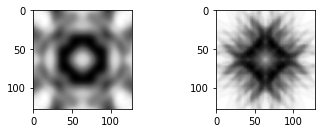

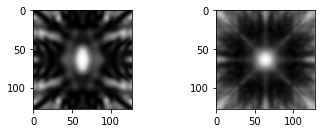

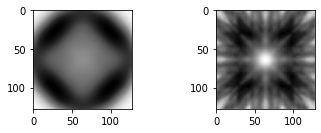

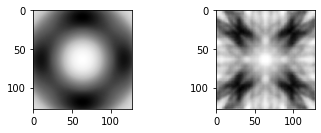

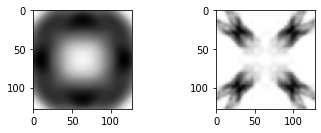

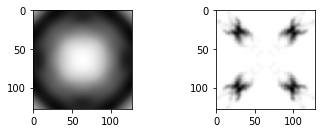

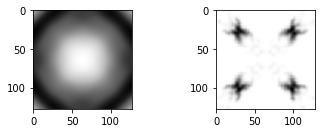

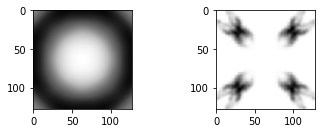

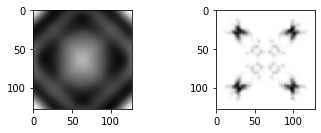

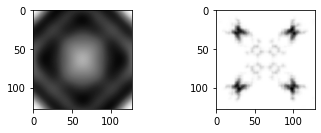

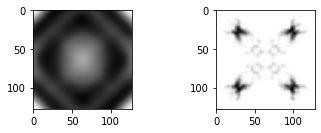

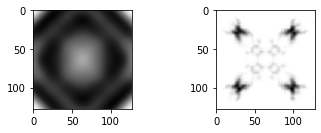

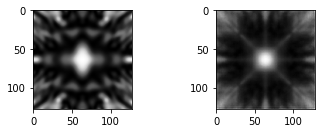

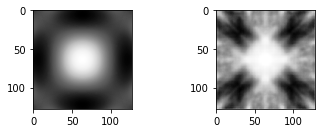

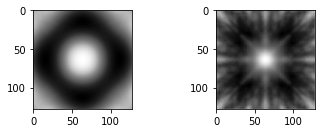

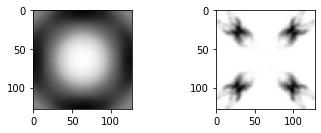

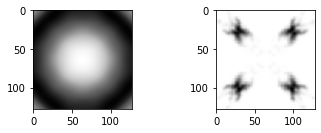

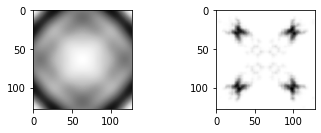

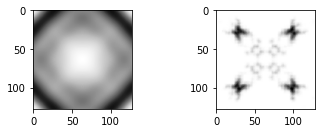

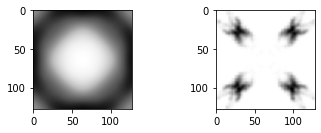

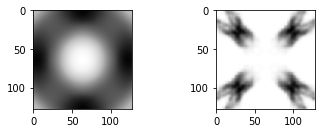

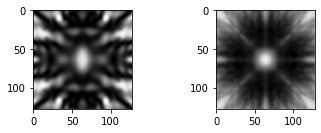

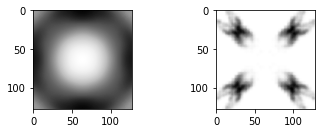

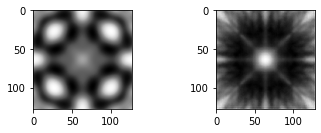

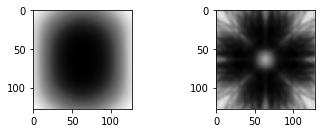

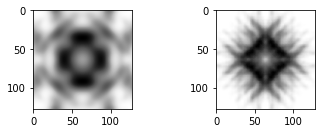

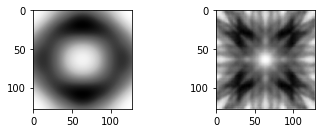

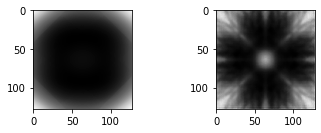

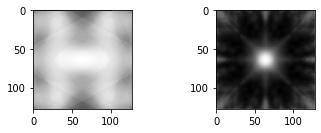

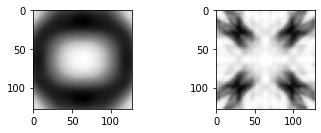

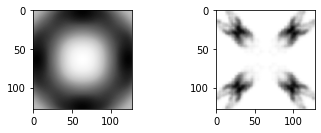

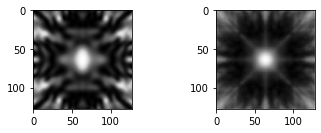

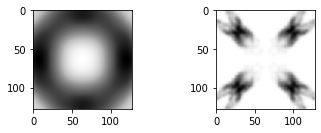

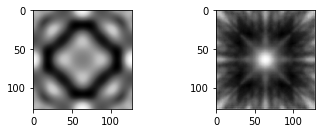

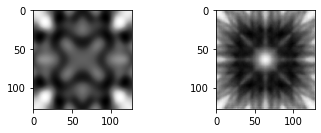

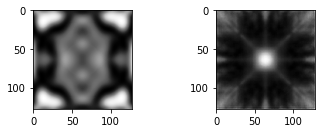

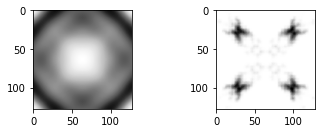

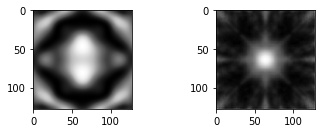

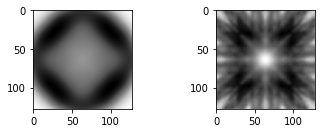

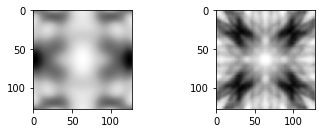

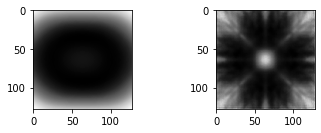

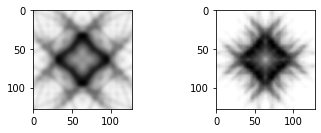

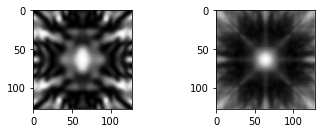

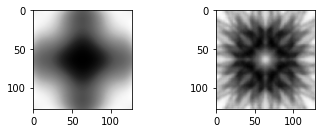

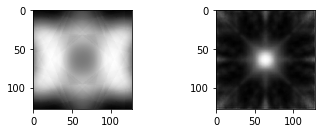

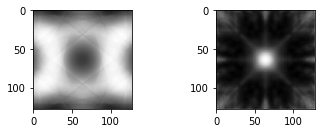

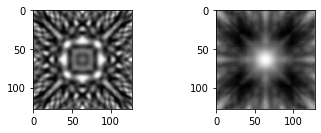

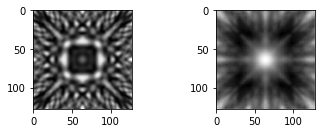

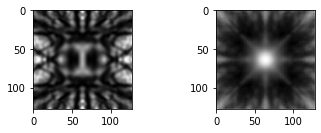

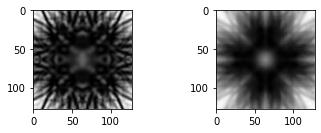

In [50]:
def Compare(vae, Image):
    z_mean, z_log_var, _ = vae.encoder.predict(Image)
    x_decoded = vae.decoder.predict(z_mean)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(Image.reshape(128, 128), cmap="Greys_r")
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(x_decoded.reshape(128, 128), cmap="Greys_r")
    

    return

for i in range(0, 100):
    Image = LACBED_Training[i].reshape(1, 128, 128, 1)
    Compare(vae, Image)